In [1]:
import tushare as ts
import time
import datetime
import sys
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
#df = Imputer().fit_transform(df)
sys.path.append('../Codes')
import DataProcessor as DP
from DataProcessor import centralize
from DataProcessor import standardize
from DataProcessor import ma_ratio

In [2]:
#获取行业分类
industrys = DP.get_industrys()

In [539]:
industry=['801120.SI']
#取行业内股票数据
data = DP.get_daily_data(industry=industry,
                         fields=['open',
                                 'high',
                                 'low',
                                 'close',
                                 'adj_factor',
                                 'turnover_rate_f',
                                 'pe_ttm',
                                 'pb',
                                 'ps_ttm',
                                 'total_mv'])
OPEN = data['open'] * data['adj_factor']
HIGH = data['high'] * data['adj_factor']
LOW = data['low'] * data['adj_factor']
CLOSE = data['close'] * data['adj_factor']
trf = data['turnover_rate_f']
pe = data['pe_ttm']
pb = data['pb']
ps = data['ps_ttm']
mv = data['total_mv']
#补缺
#CLOSE.fillna(method='ffill', inplace=True)
#OPEN.fillna(value=CLOSE, inplace=True)
#HIGH.fillna(value=CLOSE, inplace=True)
#LOW.fillna(value=CLOSE, inplace=True)

In [540]:
#上市20日空缺
'''
n_shangshi = 20
for i in range(len(OPEN.columns)):
    shangshi = np.where(np.diff(np.where(OPEN.iloc[:,0].isna())[0])!=1)[0][0]
    OPEN.iloc[shangshi:shangshi+n_shangshi, i] = np.nan
    HIGH.iloc[shangshi:shangshi+n_shangshi, i] = np.nan
    LOW.iloc[shangshi:shangshi+n_shangshi, i] = np.nan
    CLOSE.iloc[shangshi:shangshi+n_shangshi, i] = np.nan
    trf.iloc[shangshi:shangshi+n_shangshi, i] = np.nan
    pe.iloc[shangshi:shangshi+n_shangshi, i] = np.nan
    pb.iloc[shangshi:shangshi+n_shangshi, i] = np.nan
    ps.iloc[shangshi:shangshi+n_shangshi, i] = np.nan
    mv.iloc[shangshi:shangshi+n_shangshi, i] = np.nan
'''

'\nn_shangshi = 20\nfor i in range(len(OPEN.columns)):\n    shangshi = np.where(np.diff(np.where(OPEN.iloc[:,0].isna())[0])!=1)[0][0]\n    OPEN.iloc[shangshi:shangshi+n_shangshi, i] = np.nan\n    HIGH.iloc[shangshi:shangshi+n_shangshi, i] = np.nan\n    LOW.iloc[shangshi:shangshi+n_shangshi, i] = np.nan\n    CLOSE.iloc[shangshi:shangshi+n_shangshi, i] = np.nan\n    trf.iloc[shangshi:shangshi+n_shangshi, i] = np.nan\n    pe.iloc[shangshi:shangshi+n_shangshi, i] = np.nan\n    pb.iloc[shangshi:shangshi+n_shangshi, i] = np.nan\n    ps.iloc[shangshi:shangshi+n_shangshi, i] = np.nan\n    mv.iloc[shangshi:shangshi+n_shangshi, i] = np.nan\n'

In [541]:
#计算收益率，日内收益率，隔夜收益率
ror = CLOSE / CLOSE.shift() - 1
r_rinei = CLOSE / OPEN - 1
r_geye = OPEN / CLOSE.shift() - 1
rh = HIGH / OPEN - 1
rl = LOW / OPEN - 1
hl = rh - rl

In [542]:
volume_ratio = ma_ratio(trf, 1, 5)

In [543]:
lmv = np.log(mv)

In [544]:
pe = 1 / pe
ps = 1 / ps
pb = 1 / pb

In [545]:
#划分训练测试集
begin_train = '2010-01-01'
end_train = '2018-01-01'
begin_test = '2018-01-01'
end_test = '2021-01-01'

OPEN_train = OPEN.loc[(begin_train < ror.index) & (ror.index < end_train), :]
HIGH_train = HIGH.loc[(begin_train < ror.index) & (ror.index < end_train), :]
LOW_train = LOW.loc[(begin_train < ror.index) & (ror.index < end_train), :]
CLOSE_train = CLOSE.loc[(begin_train < ror.index) & (ror.index < end_train), :]

OPEN_test = OPEN.loc[(begin_test < ror.index) & (ror.index < end_test), :]
HIGH_test = HIGH.loc[(begin_test < ror.index) & (ror.index < end_test), :]
LOW_test = LOW.loc[(begin_test < ror.index) & (ror.index < end_test), :]
CLOSE_test = CLOSE.loc[(begin_test < ror.index) & (ror.index < end_test), :]

rh_train = rh.loc[(begin_train < ror.index) & (ror.index < end_train), :]
rl_train = rl.loc[(begin_train < ror.index) & (ror.index < end_train), :]

rh_test = rh.loc[(begin_test < ror.index) & (ror.index < end_test), :]
rl_test = rl.loc[(begin_test < ror.index) & (ror.index < end_test), :]

hl_train = hl.loc[(begin_train < ror.index) & (ror.index < end_train), :]
hl_test = hl.loc[(begin_test < ror.index) & (ror.index < end_test), :]

vr_train = volume_ratio.loc[(begin_train < ror.index) & (ror.index < end_train), :]
vr_test = volume_ratio.loc[(begin_test < ror.index) & (ror.index < end_test), :]

pe_train = pe.loc[(begin_train < ror.index) & (ror.index < end_train), :]
pe_test = pe.loc[(begin_test < ror.index) & (ror.index < end_test), :]

pb_train = pb.loc[(begin_train < ror.index) & (ror.index < end_train), :]
pb_test = pb.loc[(begin_test < ror.index) & (ror.index < end_test), :]

ps_train = ps.loc[(begin_train < ror.index) & (ror.index < end_train), :]
ps_test = ps.loc[(begin_test < ror.index) & (ror.index < end_test), :]

lmv_train = mv.loc[(begin_train < ror.index) & (ror.index < end_train), :]
lmv_test = mv.loc[(begin_test < ror.index) & (ror.index < end_test), :]

ror_train = ror.loc[(begin_train < ror.index) & (ror.index < end_train), :]
ror_test = ror.loc[(begin_test < ror.index) & (ror.index < end_test), :]
r_rinei_train = r_rinei.loc[(begin_train < r_rinei.index) & (r_rinei.index < end_train), :]
r_rinei_test = r_rinei.loc[(begin_test < r_rinei.index) & (r_rinei.index < end_test), :]
r_geye_train = r_geye.loc[(begin_train < r_geye.index) & (r_geye.index < end_train), :]
r_geye_test = r_geye.loc[(begin_test < r_geye.index) & (r_geye.index < end_test), :]

In [546]:
ror_train.iloc[1,:].notna().mean()

0.4270833333333333

In [547]:
#数据清洗
#r_rinei_train = r_rinei_train.loc[:, ror_train.iloc[0,:].notna()]
#r_geye_train = r_geye_train.loc[:, ror_train.iloc[0,:].notna()]
#ror_train = ror_train.loc[:, ror_train.iloc[0,:].notna()]
#ror_train.fillna(value=ror_train.mean(0), inplace=True)
#r_rinei_train.fillna(value=r_rinei_train.mean(0), inplace=True)
#r_rinei_test.fillna(value=r_rinei_test.mean(0), inplace=True)
#imp = SimpleImputer(strategy='mean')
#ror_train = DataFrame(imp.fit_transform(ror_train))
#r_rinei_train = DataFrame(imp.fit_transform(r_rinei_train))
#r_geye_train = DataFrame(imp.fit_transform(r_geye_train))

In [548]:
#预测未来n天
n = 2

In [549]:
#构造因子
y_train = centralize(ror_train.rolling(n).sum().shift(-n+1) - r_geye_train)
y_train[(r_geye_train > 0.09).fillna(False) & (r_rinei_train.abs()<1e-6).fillna(False)] = 0
#y_train = centralize(r_rinei_train)

x1_train = centralize(r_rinei_train.shift(1))
x2_train = centralize(r_rinei_train.rolling(2).mean().shift(2))
x3_train = centralize(r_rinei_train.rolling(2).mean().shift(4))
x4_train = centralize(r_rinei_train.rolling(5).mean().shift(6))
x5_train = centralize(r_rinei_train.rolling(10).mean().shift(11))
x6_train = centralize(r_rinei_train.rolling(20).mean().shift(21))
x7_train = centralize(r_rinei_train.rolling(20).mean().shift(41))

z1_train = centralize(r_geye_train.shift(1))
z2_train = centralize(r_geye_train.rolling(2).mean().shift(2))
z3_train = centralize(r_geye_train.rolling(2).mean().shift(4))
z4_train = centralize(r_geye_train.rolling(5).mean().shift(6))
z5_train = centralize(r_geye_train.rolling(10).mean().shift(11))
z6_train = centralize(r_geye_train.rolling(20).mean().shift(21))
z7_train = centralize(r_geye_train.rolling(20).mean().shift(41))

u1_train = centralize(ror_train.shift(1))
u2_train = centralize(ror_train.rolling(2).mean().shift(2))
u3_train = centralize(ror_train.rolling(2).mean().shift(4))
u4_train = centralize(ror_train.rolling(5).mean().shift(6))
u5_train = centralize(ror_train.rolling(10).mean().shift(11))
u6_train = centralize(ror_train.rolling(20).mean().shift(21))
u7_train = centralize(ror_train.rolling(20).mean().shift(41))

h1_train = centralize(rh_train.shift(1))
h2_train = centralize(rh_train.rolling(2).mean().shift(2))
h3_train = centralize(rh_train.rolling(2).mean().shift(4))
h4_train = centralize(rh_train.rolling(5).mean().shift(6))
h5_train = centralize(rh_train.rolling(10).mean().shift(11))
h6_train = centralize(rh_train.rolling(20).mean().shift(21))
h7_train = centralize(rh_train.rolling(20).mean().shift(41))

l1_train = centralize(rl_train.shift(1))
l2_train = centralize(rl_train.rolling(2).mean().shift(2))
l3_train = centralize(rl_train.rolling(2).mean().shift(4))
l4_train = centralize(rl_train.rolling(5).mean().shift(6))
l5_train = centralize(rl_train.rolling(10).mean().shift(11))
l6_train = centralize(rl_train.rolling(20).mean().shift(21))
l7_train = centralize(rl_train.rolling(20).mean().shift(41))

hl1_train = centralize(hl_train.shift(1))
hl2_train = centralize(hl_train.rolling(2).mean().shift(2))
hl3_train = centralize(hl_train.rolling(2).mean().shift(4))
hl4_train = centralize(hl_train.rolling(5).mean().shift(6))
hl5_train = centralize(hl_train.rolling(10).mean().shift(11))
hl6_train = centralize(hl_train.rolling(20).mean().shift(21))
hl7_train = centralize(hl_train.rolling(20).mean().shift(41))

#vr pe pb ps mv
vr_train = centralize(vr_train.shift(1))
pe_train = centralize(pe_train.shift(1))
pb_train = centralize(pb_train.shift(1))
ps_train = centralize(ps_train.shift(1))
lmv_train = centralize(lmv_train.shift(1))

df_train = DataFrame({'y':y_train.values.flatten(),
               'x1':x1_train.values.flatten(),
               'x2':x2_train.values.flatten(),
               'x3':x3_train.values.flatten(),
               'x4':x4_train.values.flatten(),
               'x5':x5_train.values.flatten(),
               'x6':x6_train.values.flatten(),
               'x7':x7_train.values.flatten(),
               'z1':z1_train.values.flatten(),
               'z2':z2_train.values.flatten(),
               'z3':z3_train.values.flatten(),
               'z4':z4_train.values.flatten(),
               'z5':z5_train.values.flatten(),
               'z6':z6_train.values.flatten(),
               'z7':z7_train.values.flatten(),
               'u1':u1_train.values.flatten(),
               'u2':u2_train.values.flatten(),
               'u3':u3_train.values.flatten(),
               'u4':u4_train.values.flatten(),
               'u5':u5_train.values.flatten(),
               'u6':u6_train.values.flatten(),
               'u7':u7_train.values.flatten(),
               'h1':h1_train.values.flatten(),
               'h2':h2_train.values.flatten(),
               'h3':h3_train.values.flatten(),
               'h4':h4_train.values.flatten(),
               'h5':h5_train.values.flatten(),
               'h6':h6_train.values.flatten(),
               'h7':h7_train.values.flatten(),
               'l1':l1_train.values.flatten(),
               'l2':l2_train.values.flatten(),
               'l3':l3_train.values.flatten(),
               'l4':l4_train.values.flatten(),
               'l5':l5_train.values.flatten(),
               'l6':l6_train.values.flatten(),
               'l7':l7_train.values.flatten(),
               'hl1':hl1_train.values.flatten(),
               'hl2':hl2_train.values.flatten(),
               'hl3':hl3_train.values.flatten(),
               'hl4':hl4_train.values.flatten(),
               'hl5':hl5_train.values.flatten(),
               'hl6':hl6_train.values.flatten(),
               'hl7':hl7_train.values.flatten(),
               'vr':vr_train.values.flatten(),
               'pe':pe_train.values.flatten(),
               'pb':pb_train.values.flatten(),
               'ps':ps_train.values.flatten(),
               'lmv':lmv_train.values.flatten(),
                      
                     })

y_test = centralize(ror_test.rolling(n).sum().shift(-n+1) - r_geye_test)
#y_test = centralize(r_rinei_test)

x1_test = centralize(r_rinei_test.shift(1))
x2_test = centralize(r_rinei_test.rolling(2).mean().shift(2))
x3_test = centralize(r_rinei_test.rolling(2).mean().shift(4))
x4_test = centralize(r_rinei_test.rolling(5).mean().shift(6))
x5_test = centralize(r_rinei_test.rolling(10).mean().shift(11))
x6_test = centralize(r_rinei_test.rolling(20).mean().shift(21))
x7_test = centralize(r_rinei_test.rolling(20).mean().shift(41))

z1_test = centralize(r_geye_test.shift(1))
z2_test = centralize(r_geye_test.rolling(2).mean().shift(2))
z3_test = centralize(r_geye_test.rolling(2).mean().shift(4))
z4_test = centralize(r_geye_test.rolling(5).mean().shift(6))
z5_test = centralize(r_geye_test.rolling(10).mean().shift(11))
z6_test = centralize(r_geye_test.rolling(20).mean().shift(21))
z7_test = centralize(r_geye_test.rolling(20).mean().shift(41))

u1_test = centralize(ror_test.shift(1))
u2_test = centralize(ror_test.rolling(2).mean().shift(2))
u3_test = centralize(ror_test.rolling(2).mean().shift(4))
u4_test = centralize(ror_test.rolling(5).mean().shift(6))
u5_test = centralize(ror_test.rolling(10).mean().shift(11))
u6_test = centralize(ror_test.rolling(20).mean().shift(21))
u7_test = centralize(ror_test.rolling(20).mean().shift(41))

h1_test = centralize(rh_test.shift(1))
h2_test = centralize(rh_test.rolling(2).mean().shift(2))
h3_test = centralize(rh_test.rolling(2).mean().shift(4))
h4_test = centralize(rh_test.rolling(5).mean().shift(6))
h5_test = centralize(rh_test.rolling(10).mean().shift(11))
h6_test = centralize(rh_test.rolling(20).mean().shift(21))
h7_test = centralize(rh_test.rolling(20).mean().shift(41))

l1_test = centralize(rl_test.shift(1))
l2_test = centralize(rl_test.rolling(2).mean().shift(2))
l3_test = centralize(rl_test.rolling(2).mean().shift(4))
l4_test = centralize(rl_test.rolling(5).mean().shift(6))
l5_test = centralize(rl_test.rolling(10).mean().shift(11))
l6_test = centralize(rl_test.rolling(20).mean().shift(21))
l7_test = centralize(rl_test.rolling(20).mean().shift(41))

hl1_test = centralize(hl_test.shift(1))
hl2_test = centralize(hl_test.rolling(2).mean().shift(2))
hl3_test = centralize(hl_test.rolling(2).mean().shift(4))
hl4_test = centralize(hl_test.rolling(5).mean().shift(6))
hl5_test = centralize(hl_test.rolling(10).mean().shift(11))
hl6_test = centralize(hl_test.rolling(20).mean().shift(21))
hl7_test = centralize(hl_test.rolling(20).mean().shift(41))

#vr pe pb ps mv
vr_test = centralize(vr_test.shift(1))
pe_test = centralize(pe_test.shift(1))
pb_test = centralize(pb_test.shift(1))
ps_test = centralize(ps_test.shift(1))
lmv_test = centralize(lmv_test.shift(1))


df_test = DataFrame({'y':y_test.values.flatten(),
               'x1':x1_test.values.flatten(),
               'x2':x2_test.values.flatten(),
               'x3':x3_test.values.flatten(),
               'x4':x4_test.values.flatten(),
               'x5':x5_test.values.flatten(),
               'x6':x6_test.values.flatten(),
               'x7':x7_test.values.flatten(),
               'z1':z1_test.values.flatten(),
               'z2':z2_test.values.flatten(),
               'z3':z3_test.values.flatten(),
               'z4':z4_test.values.flatten(),
               'z5':z5_test.values.flatten(),
               'z6':z6_test.values.flatten(),
               'z7':z7_test.values.flatten(),
               'u1':u1_test.values.flatten(),
               'u2':u2_test.values.flatten(),
               'u3':u3_test.values.flatten(),
               'u4':u4_test.values.flatten(),
               'u5':u5_test.values.flatten(),
               'u6':u6_test.values.flatten(),
               'u7':u7_test.values.flatten(),
               'h1':h1_test.values.flatten(),
               'h2':h2_test.values.flatten(),
               'h3':h3_test.values.flatten(),
               'h4':h4_test.values.flatten(),
               'h5':h5_test.values.flatten(),
               'h6':h6_test.values.flatten(),
               'h7':h7_test.values.flatten(),
               'l1':l1_test.values.flatten(),
               'l2':l2_test.values.flatten(),
               'l3':l3_test.values.flatten(),
               'l4':l4_test.values.flatten(),
               'l5':l5_test.values.flatten(),
               'l6':l6_test.values.flatten(),
               'l7':l7_test.values.flatten(),
               'hl1':hl1_test.values.flatten(),
               'hl2':hl2_test.values.flatten(),
               'hl3':hl3_test.values.flatten(),
               'hl4':hl4_test.values.flatten(),
               'hl5':hl5_test.values.flatten(),
               'hl6':hl6_test.values.flatten(),
               'hl7':hl7_test.values.flatten(),
               'vr':vr_test.values.flatten(),
               'pe':pe_test.values.flatten(),
               'pb':pb_test.values.flatten(),
               'ps':ps_test.values.flatten(),
               'lmv':lmv_test.values.flatten(),
                    })

In [550]:
#y_train[(LOW_train==HIGH_train) & ((OPEN_train-CLOSE_train.shift())>1e-6)] = np.nan
#ror_test = ror_test.shift(-1)
#ror_test[(LOW_test==HIGH_test) & ((OPEN_test-CLOSE_test.shift())>1e-6)] = 0
#ror_test = ror_test.shift()

In [551]:
df_train.corr().iloc[0,:].abs().sort_values(ascending=False)

y      1.000000
l3     0.029554
x3     0.025464
hl1    0.022440
u3     0.022067
l1     0.018996
h4     0.013225
z1     0.012823
h3     0.012699
z2     0.012054
x2     0.011715
z4     0.011393
x7     0.010815
x4     0.010495
hl4    0.010242
hl5    0.009699
h1     0.009614
hl2    0.009236
h5     0.009039
pe     0.008874
u7     0.008770
x1     0.008729
z6     0.008394
hl6    0.008084
h6     0.007671
vr     0.007539
x6     0.007058
hl3    0.006977
x5     0.006632
pb     0.006433
h2     0.006115
l5     0.006078
l6     0.005973
l2     0.005951
u5     0.005468
l7     0.004863
z7     0.004729
u2     0.004442
h7     0.003852
ps     0.003687
z3     0.002770
u4     0.002293
lmv    0.001987
u1     0.001818
l4     0.001002
u6     0.000848
hl7    0.000613
z5     0.000033
Name: y, dtype: float64

In [552]:
model = smf.ols('y~x1+z1+x2+z2+u3+h1+h2+h3+hl1+hl2+ps+lmv+pe+pb', data=df_train).fit()
model.tvalues

Intercept    -1.513105
x1           -5.476984
z1            4.712853
x2          -10.595447
z2            5.442848
u3           -5.523773
h1            3.835585
h2            8.931573
h3           -2.199856
hl1           2.167256
hl2          -5.008236
ps            0.678134
lmv           1.628007
pe           -2.407386
pb            2.390748
dtype: float64

300741.SZ    0.010543
000860.SZ    0.003989
600519.SH    0.003807
603755.SH    0.002513
002557.SZ    0.002179
002946.SZ    0.002075
600059.SH    0.001949
600073.SH    0.001878
002702.SZ    0.001872
300791.SZ    0.001772
Name: 2020-07-13 00:00:00, dtype: float64


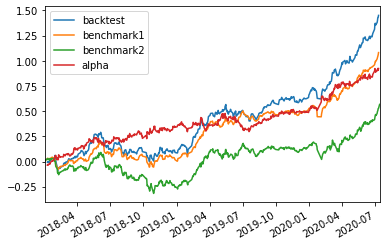

In [555]:
#调仓周期
m = 2
y_hat = DataFrame(model.predict(df_test).values.reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
position = (y_hat.gt(y_hat.quantile(0.95, 1), 0))
ror_huice = position * (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m
ror_huice[ror_huice==0] = np.nan
ror_huice.mean(1).cumsum().plot()
benchmark1 = (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m
benchmark1.mean(1).cumsum().plot()
benchmark2 = ror_test
benchmark2.mean(1).cumsum().plot()
(ror_huice.mean(1).cumsum() - benchmark2.mean(1).cumsum()).plot()
plt.legend(['backtest', 'benchmark1', 'benchmark2', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [556]:
position.sum(1)

2018-01-02    0
2018-01-03    0
2018-01-04    0
2018-01-05    0
2018-01-08    0
             ..
2020-07-07    4
2020-07-08    4
2020-07-09    4
2020-07-10    4
2020-07-13    4
Length: 613, dtype: int64

In [557]:
x1_test = centralize(r_rinei_test)
x2_test = centralize(r_rinei_test.rolling(2).mean().shift(1))
x3_test = centralize(r_rinei_test.rolling(2).mean().shift(3))
x4_test = centralize(r_rinei_test.rolling(5).mean().shift(5))
x5_test = centralize(r_rinei_test.rolling(10).mean().shift(10))
x6_test = centralize(r_rinei_test.rolling(20).mean().shift(20))
x7_test = centralize(r_rinei_test.rolling(20).mean().shift(40))

z1_test = centralize(r_geye_test)
z2_test = centralize(r_geye_test.rolling(2).mean().shift(1))
z3_test = centralize(r_geye_test.rolling(2).mean().shift(3))
z4_test = centralize(r_geye_test.rolling(5).mean().shift(5))
z5_test = centralize(r_geye_test.rolling(10).mean().shift(10))
z6_test = centralize(r_geye_test.rolling(20).mean().shift(20))
z7_test = centralize(r_geye_test.rolling(20).mean().shift(40))

u1_test = centralize(ror_test)
u2_test = centralize(ror_test.rolling(2).mean().shift(1))
u3_test = centralize(ror_test.rolling(2).mean().shift(3))
u4_test = centralize(ror_test.rolling(5).mean().shift(5))
u5_test = centralize(ror_test.rolling(10).mean().shift(10))
u6_test = centralize(ror_test.rolling(20).mean().shift(20))
u7_test = centralize(ror_test.rolling(20).mean().shift(40))

h1_test = centralize(rh_test)
h2_test = centralize(rh_test.rolling(2).mean().shift(1))
h3_test = centralize(rh_test.rolling(2).mean().shift(3))
h4_test = centralize(rh_test.rolling(5).mean().shift(5))
h5_test = centralize(rh_test.rolling(10).mean().shift(10))
h6_test = centralize(rh_test.rolling(20).mean().shift(20))
h7_test = centralize(rh_test.rolling(20).mean().shift(40))

l1_test = centralize(rl_test)
l2_test = centralize(rl_test.rolling(2).mean().shift(1))
l3_test = centralize(rl_test.rolling(2).mean().shift(3))
l4_test = centralize(rl_test.rolling(5).mean().shift(5))
l5_test = centralize(rl_test.rolling(10).mean().shift(10))
l6_test = centralize(rl_test.rolling(20).mean().shift(20))
l7_test = centralize(rl_test.rolling(20).mean().shift(40))

hl1_test = centralize(hl_test)
hl2_test = centralize(hl_test.rolling(2).mean().shift(1))
hl3_test = centralize(hl_test.rolling(2).mean().shift(3))
hl4_test = centralize(hl_test.rolling(5).mean().shift(5))
hl5_test = centralize(hl_test.rolling(10).mean().shift(10))
hl6_test = centralize(hl_test.rolling(20).mean().shift(20))
hl7_test = centralize(hl_test.rolling(20).mean().shift(40))

#vr pe pb ps mv
vr_test = centralize(vr_test)
pe_test = centralize(pe_test)
pb_test = centralize(pb_test)
ps_test = centralize(ps_test)
lmv_test = centralize(lmv_test)

df_test = DataFrame({'y':y_test.values.flatten(),
               'x1':x1_test.values.flatten(),
               'x2':x2_test.values.flatten(),
               'x3':x3_test.values.flatten(),
               'x4':x4_test.values.flatten(),
               'x5':x5_test.values.flatten(),
               'x6':x6_test.values.flatten(),
               'x7':x7_test.values.flatten(),
               'z1':z1_test.values.flatten(),
               'z2':z2_test.values.flatten(),
               'z3':z3_test.values.flatten(),
               'z4':z4_test.values.flatten(),
               'z5':z5_test.values.flatten(),
               'z6':z6_test.values.flatten(),
               'z7':z7_test.values.flatten(),
               'u1':u1_test.values.flatten(),
               'u2':u2_test.values.flatten(),
               'u3':u3_test.values.flatten(),
               'u4':u4_test.values.flatten(),
               'u5':u5_test.values.flatten(),
               'u6':u6_test.values.flatten(),
               'u7':u7_test.values.flatten(),
               'h1':h1_test.values.flatten(),
               'h2':h2_test.values.flatten(),
               'h3':h3_test.values.flatten(),
               'h4':h4_test.values.flatten(),
               'h5':h5_test.values.flatten(),
               'h6':h6_test.values.flatten(),
               'h7':h7_test.values.flatten(),
               'l1':l1_test.values.flatten(),
               'l2':l2_test.values.flatten(),
               'l3':l3_test.values.flatten(),
               'l4':l4_test.values.flatten(),
               'l5':l5_test.values.flatten(),
               'l6':l6_test.values.flatten(),
               'l7':l7_test.values.flatten(),
               'hl1':hl1_test.values.flatten(),
               'hl2':hl2_test.values.flatten(),
               'hl3':hl3_test.values.flatten(),
               'hl4':hl4_test.values.flatten(),
               'hl5':hl5_test.values.flatten(),
               'hl6':hl6_test.values.flatten(),
               'hl7':hl7_test.values.flatten(),
               'vr':vr_test.values.flatten(),
               'pe':pe_test.values.flatten(),
               'pb':pb_test.values.flatten(),
               'ps':ps_test.values.flatten(),
               'lmv':lmv_test.values.flatten(),
                    })
y_hat = DataFrame(model.predict(df_test).values.reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

300741.SZ    0.009150
600519.SH    0.004005
000858.SZ    0.003002
000860.SZ    0.002934
600059.SH    0.002723
603755.SH    0.002597
600073.SH    0.002431
002840.SZ    0.002371
002695.SZ    0.002165
300791.SZ    0.002072
Name: 2020-07-13 00:00:00, dtype: float64


In [465]:
df_train = df_train.dropna()
model = RandomForestRegressor(n_estimators=10).fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
model.feature_importances_

array([0.05159753, 0.05007378, 0.04443164, 0.04619165, 0.04480049,
       0.04128151, 0.04127881, 0.05454827, 0.05270984, 0.05264996,
       0.04963717, 0.05406033, 0.04655707, 0.04854932, 0.0502602 ,
       0.0494474 , 0.04531465, 0.04479211, 0.04590302, 0.0421521 ,
       0.04376315])